In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
import seaborn as sns
from numpy.linalg import norm


# ADD PATH TO PLAYLIST FOLDER HERE
folder_path = '/Users/john/john/projects/dealing_with_data/MusicRecommendation/playlists'

In [52]:
# dont run this.

#PLAYLIST VS ARTIST - OLD VERSION
# for folder structure in which all playlists are in one directory, and user ownership is not specified
def make_matrix_old():
    # Initialize a DataFrame for the final output
    final_df = pd.DataFrame()

    # Set for storing unique artist names
    all_artists = set()

    # List all CSV files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            playlist_df = pd.read_csv(file_path)
            playlist_name = os.path.splitext(filename)[0]
            artist_count = {}

            for _, row in playlist_df.iterrows():
                # Extract and process artists
                artists = [artist.strip() for artist in row['Artist Name(s)'].split(',')]
                for artist in artists:
                    all_artists.add(artist)
                    artist_count[artist] = artist_count.get(artist, 0) + 1

            # Create a DataFrame for the current playlist
            playlist_artist_df = pd.DataFrame([{'Playlist Name': playlist_name, **artist_count}])
            final_df = pd.concat([final_df, playlist_artist_df], ignore_index=True)

    # Add columns for any missing artists in each playlist
    missing_artists = all_artists - set(final_df.columns)
    for artist in missing_artists:
        final_df[artist] = 0

    return final_df

In [53]:
# PLAYLIST VS ARTIST
# where folder_path contains directories named by user, containing each user's playlists as csv files
# used Exportify for Spotify tool.

def make_matrix_by_playlist():
    # Initialize a DataFrame for the final output
    final_df = pd.DataFrame()

    # Set for storing unique artist names
    all_artists = set()

    # Iterate over each subfolder in the folder_path
    for user_folder in os.listdir(folder_path):
        user_folder_path = os.path.join(folder_path, user_folder)
        if os.path.isdir(user_folder_path):
            # List all CSV files in the subfolder
            for filename in os.listdir(user_folder_path):
                if filename.endswith('.csv'):
                    file_path = os.path.join(user_folder_path, filename)
                    playlist_df = pd.read_csv(file_path)
                    playlist_name = f"{user_folder}/{os.path.splitext(filename)[0]}"
                    artist_count = {}

                    for _, row in playlist_df.iterrows():
                        # Check if 'Artist Name(s)' is a string and not NaN
                        if isinstance(row['Artist Name(s)'], str):
                            artists = [str(artist).strip() for artist in row['Artist Name(s)'].split(',')]
                            for artist in artists:
                                all_artists.add(artist)
                                artist_count[artist] = artist_count.get(artist, 0) + 1
                        else:
                            # Handle non-string 'Artist Name(s)' values here if needed
                            pass

                    # Create a DataFrame for the current playlist
                    playlist_artist_df = pd.DataFrame([{'Playlist Name': playlist_name, **artist_count}])
                    final_df = pd.concat([final_df, playlist_artist_df], ignore_index=True)

    # Add columns for any missing artists in each playlist
    missing_artists = all_artists - set(final_df.columns)
    for artist in missing_artists:
        final_df[artist] = 0

    return final_df

playlist_df = make_matrix_by_playlist()
playlist_original_df = playlist_df #saved for later use
playlist_df.to_csv("raw_by_PLAYLISTS.csv", index=False)
playlist_df = playlist_df.apply(pd.to_numeric, errors='coerce')

In [54]:
# MATRIX BY USER vs ARTIST

def make_matrix_by_user():
    # Initialize a DataFrame for the final output
    final_df = pd.DataFrame()
    all_artists = set()

    # Iterate over each subfolder (user) in the folder_path
    for user_folder in os.listdir(folder_path):
        user_folder_path = os.path.join(folder_path, user_folder)
        if os.path.isdir(user_folder_path):
            # Initialize a dict to store artist counts for the user
            user_artist_count = {}

            # List all CSV files in the subfolder (user folder)
            for filename in os.listdir(user_folder_path):
                if filename.endswith('.csv'):
                    file_path = os.path.join(user_folder_path, filename)
                    playlist_df = pd.read_csv(file_path)

                    for _, row in playlist_df.iterrows():
                        # Check if 'Artist Name(s)' is a string and not NaN
                        if isinstance(row['Artist Name(s)'], str):
                            artists = [str(artist).strip() for artist in row['Artist Name(s)'].split(',')]
                            for artist in artists:
                                all_artists.add(artist)
                                user_artist_count[artist] = user_artist_count.get(artist, 0) + 1
                        else:
                            # Handle non-string 'Artist Name(s)' values here if needed
                            pass

            # Create a DataFrame for the current user
            user_artist_df = pd.DataFrame([{'User': user_folder, **user_artist_count}])
            final_df = pd.concat([final_df, user_artist_df], ignore_index=True)

    # Add columns for any missing artists in each user's data
    missing_artists = all_artists - set(final_df.columns)
    for artist in missing_artists:
        final_df[artist] = 0

    return final_df

user_df = make_matrix_by_user()
users_original_df = user_df #saved for columns later
user_df.to_csv("raw_by_USER.csv", index=False)
user_df = user_df.apply(pd.to_numeric, errors='coerce')


In [15]:
# # NORMALIZATION row-wise 

# # simple min-max method
# user_df = (user_df.sub(user_df.min(axis=1), axis=0)).div(user_df.max(axis=1) - user_df.min(axis=1), axis=0)
# playlist_df = (playlist_df.sub(playlist_df.min(axis=1), axis=0)).div(playlist_df.max(axis=1) - playlist_df.min(axis=1), axis=0)

# #Z SCORE METHOD - takes into account stdev per row which we dont care about so ignore lowkey
# #user_df = user_df.sub(user_df.mean(axis=1), axis=0).div(user_df.std(axis=1), axis=0)
# #playlist_df = playlist_df.sub(playlist_df.mean(axis=1), axis=0).div(playlist_df.std(axis=1), axis=0)

# #CONVERT TO PANDAS
# user_df = np.array(user_df)
# playlist_df = np.array(playlist_df)


In [55]:
# NORMALIZATION -- save to test later
# want to normalize by row to find recs for each user
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler instance
scaler = MinMaxScaler()

# Transpose the matrix b/c MinMaxScaler works on columns by default. We want to work with rows -- normalize for each user
# `fit_transform` finds min and max for each row and scales values accordingly
# `.T` turns matrix back to original orientation
user_df_normalized = scaler.fit_transform(user_df.T).T
playlist_df_normalized = scaler.fit_transform(playlist_df.T).T

In [56]:
## ALTERNATING MINIMIZATION FUNCTIONS

def solve_V(X, U):
    """
    Given matrix X of shape (n, m),  U of shape (n, k), returns V of shape (m, k) such that X = U * transpose(V)
    :param X:
    :param U:
    :return:
    """
    n, m = X.shape
    k = U.shape[1]
    V = np.zeros((m, k))
    for i in range(m):
        column = X[:, i].flatten()
        indexes = np.argwhere(~np.isnan(column)).flatten()
        U_omega = U[indexes, :]
        y_omega = X[indexes, i]
        V[i, :] = np.linalg.lstsq(U_omega, y_omega)[0]
    return V


def alt_min(X, U_0, T):
    """
    Given X, initial values of U and number of iterations T, returns U, V such that X = U * transpose(V)
    :param X:
    :param U_0:
    :param T:
    :return:
    """
    U = U_0
    for _ in range(T):
        V = solve_V(X, U)
        U = solve_V(np.transpose(X), V)
    return U, V

def alt_min2(X, U_0, T, tol=1e-3):
    """
    Given X, initial values of U, number of iterations T, and a tolerance, returns U, V such that X = U * transpose(V)
    Also stops if the change in U and V is below a tolerance.
    :param X:
    :param U_0:
    :param T:
    :param tol: tolerance for convergence
    :return:
    """
    U = U_0
    U_old = np.zeros_like(U)
    V_old = np.zeros((X.shape[1], U.shape[1]))
    iter = 0

    for _ in range(T):
        V = solve_V(X, U)
        U = solve_V(np.transpose(X), V)

        # Check for convergence
        if norm(U - U_old, ord='fro') < tol and norm(V - V_old, ord='fro') < tol:
            break
        
        U_old = U.copy()
        V_old = V.copy()
        iter += 1

    print('Number of Alt Min Iterations:' + str(iter))
    return U, V


def matrix_completion(X, T, k):
    """
    Given a matrix X with missing values, fills missing values in X
    :param X:
    :param T:
    :param k:
    :return:
    """
    X_hat = np.nan_to_num(X)
    U, e, V_t = np.linalg.svd(X_hat, full_matrices=True)
    U, V = alt_min(X, U[:, :k], T)
    X_filled = np.matmul(U, np.transpose(V))
    return X_filled

In [ ]:
## PARAMETER OPTIMIZATION - chose k

def split_data(data_matrix, test_ratio=0.2):
    """
    Split the data into training and test sets.
    """
    np.random.seed(0)  # For reproducibility
    mask = np.random.rand(*data_matrix.shape) < test_ratio

    # Create masks for non-NaN values
    non_nan_mask = ~np.isnan(data_matrix)

    # Split data into training and test sets
    test_data = np.where(mask & non_nan_mask, data_matrix, np.nan)
    training_data = np.where(~mask & non_nan_mask, data_matrix, np.nan)

    # Create masks for training and test data
    mask_train = ~np.isnan(training_data)
    mask_test = ~np.isnan(test_data)

    return training_data, test_data, mask_train, mask_test

def compute_error(A_filled, A_true, mask):
    """
    Compute the error between the filled matrix and the true matrix.
    """
    # Ensure shapes are compatible
    if A_filled.shape != A_true.shape or mask.shape != A_filled.shape:
        raise ValueError("Shapes of A_filled, A_true, and mask must match.")

    return np.sum((A_filled[mask] - A_true[mask]) ** 2)


def k_error(max_k, training_data, test_data, mask_train, mask_test, T, type, min_k=1):
    training_errors = []
    test_errors = []
    k_values = range(min_k, max_k)

    for k in range(min_k, max_k):  # max_k is the maximum rank you want to test
        A_filled = matrix_completion(training_data, T, k)
        training_error = compute_error(A_filled, training_data, mask_train)

        B_filled = matrix_completion(training_data, T, k)
        test_error = compute_error(B_filled, test_data, mask_test)

        # Append errors to the lists
        training_errors.append(training_error)
        test_errors.append(test_error)

        print(f"k={k}, Training Error: {training_error}, Test Error: {test_error}")

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, training_errors, label='Training Error')
    plt.plot(k_values, test_errors, label='Test Error')
    plt.xlabel('Rank Parameter k')
    plt.ylabel('Error')
    if type == 'user':
        plt.title('USERS - Training and Test Errors vs Rank Parameter k')
    else: 
        plt.title('PLAYLISTS - Training and Test Errors vs Rank Parameter k')
    plt.legend()
    plt.show()
    plt.plot(k_values, training_errors, label='Training Error')
    plt.plot(k_values, test_errors, label='Test Error')

# Labeling
    plt.xlabel('Rank Parameter k')
    plt.ylabel('Error')
    if type == 'user':
        plt.title('USERS - Training and Test Errors vs Rank Parameter k')
        plt.xlim(5.5, 9)  # Zoom in on the x-axis from 5 to 7
        plt.ylim(0, 13) # Zoom in on the y-axis from 0 to 30

        plt.legend()
        plt.show()
    else: 
        plt.title('PLAYLISTS - Training and Test Errors vs Rank Parameter k')



# USERS
data_matrix = user_df
training_data, test_data, mask_train, mask_test = split_data(data_matrix)
max_k = 15
T = 50
k_error(max_k, training_data, test_data, mask_train, mask_test, T, 'user')

# PLAYLISTS
data_matrix = playlist_df
training_data, test_data, mask_train, mask_test = split_data(data_matrix)
min_k = 30
max_k = 60
T = 50
k_error(max_k, training_data, test_data, mask_train, mask_test, T, 'playlist', min_k)


In [59]:
# run on USER matrix
user_new = matrix_completion(user_df_normalized, 10, 10)
user_new = pd.DataFrame(user_new)
user_new.columns = users_original_df.columns
user_new.index = users_original_df['User']
user_new.to_csv("complete_users.csv", index=True)


# run on PLAYLIST matrix
playlist_new = matrix_completion(playlist_df_normalized, 100, 58)
playlist_new = pd.DataFrame(playlist_new)
playlist_new.columns = playlist_original_df.columns
playlist_new.index = playlist_original_df['Playlist Name']
playlist_new.to_csv("complete_playlist.csv", index=True)

/var/folders/lm/dmlc5y790cq1twzy4dtrk2rc0000gn/T/ipykernel_16682/3649065614.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V[i, :] = np.linalg.lstsq(U_omega, y_omega)[0]
/var/folders/lm/dmlc5y790cq1twzy4dtrk2rc0000gn/T/ipykernel_16682/3649065614.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  V[i, :] = np.linalg.lstsq(U_omega, y_omega)[0]


Analysis of Completed Matrices by Playlist & User

In [60]:
## RECOMMEND
max_values_by_row = user_new.max(axis=1)
# should just be 1s if normalized min max
print("Maximum values by row:")
print(max_values_by_row)

max_values_columns = user_new.idxmax(axis=1)
print("\nArtist w greatest # of songs per user:")
print(max_values_columns)

print("\nMaximum values by row and their corresponding columns:")
for index, (value, column) in enumerate(zip(max_values_by_row, max_values_columns)):
    print(f"Row {index}: Max Value = {value}, Column = {column}")

Maximum values by row:
User
Cece       1.000000
Tyler      1.000000
Sara       1.000000
Jeong      1.000000
Malia      1.000000
Carter     1.000000
Leo        1.011669
Aleena     1.000000
Rhea       1.000000
Alperen    1.000000
dtype: float64

Artist w greatest # of songs per user:
User
Cece       Lizzy McAlpine
Tyler         Still Woozy
Sara         Taylor Swift
Jeong         The Strokes
Malia      Kendrick Lamar
Carter       Taylor Swift
Leo          Saint Levant
Aleena       Taylor Swift
Rhea                Drake
Alperen      Saint Levant
dtype: object

Maximum values by row and their corresponding columns:
Row 0: Max Value = 1.0000000000000009, Column = Lizzy McAlpine
Row 1: Max Value = 1.0000000000000007, Column = Still Woozy
Row 2: Max Value = 1.0000000000000004, Column = Taylor Swift
Row 3: Max Value = 0.9999999999999993, Column = The Strokes
Row 4: Max Value = 1.0, Column = Kendrick Lamar
Row 5: Max Value = 1.0000000000000018, Column = Taylor Swift
Row 6: Max Value = 1.01166925

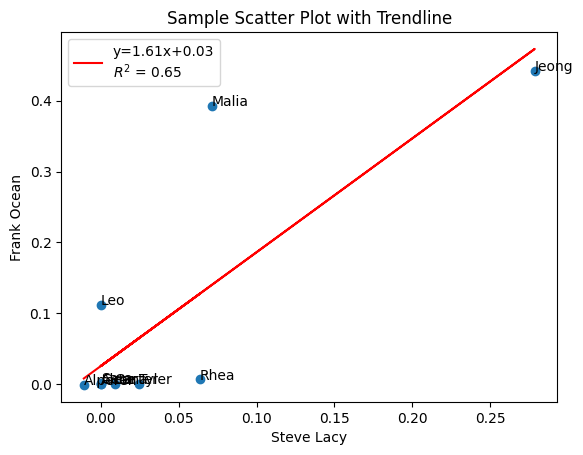

In [61]:
## CORRELATION BETWEEN ARTISTS ACROSS PLAYLISTS

artist1 = 'Steve Lacy'
artist2 = 'Frank Ocean'

# chose USER OR PLAYLIST HERE -- playlist is how much steve lacy and frank ocean is on each playlist. user steve lacy and frank ocean in all user's playlists
new_df = user_new
x = new_df[artist1]
y = new_df[artist2]

slope, intercept = np.polyfit(x, y, 1)
trendline = slope * x + intercept

# Calculate R^2 value
r_squared = np.corrcoef(x, y)[0, 1]**2

# Create scatter plot
plt.scatter(x, y)

# Add trendline
plt.plot(x, trendline, color='red', label=f'y={slope:.2f}x+{intercept:.2f}\n$R^2$ = {r_squared:.2f}')

# Adding titles and labels
for i, txt in enumerate(new_df.index):
    plt.annotate(txt, (x[i], y[i]))
    
plt.title("Sample Scatter Plot with Trendline")
plt.xlabel(artist1)
plt.ylabel(artist2)
plt.legend()
plt.show()


In [62]:
## FIND SIMILAR ARTISTS

data_matrix = user_new.drop('User', axis=1)
artists_transposed = data_matrix.T

# Calculate pairwise Euclidean distances using the transposed data
distances_artists = pd.DataFrame(squareform(pdist(artists_transposed, 'euclidean')), 
                                 index=artists_transposed.index, 
                                 columns=artists_transposed.index)

np.fill_diagonal(distances_artists.values, np.inf)

for artist in distances_artists.index:
    most_similar_artist = distances_artists.loc[artist].idxmin()
    print(f"{artist} is most similar to {most_similar_artist}")


Cynthia Erivo is most similar to Ethan Bortnick
Still Woozy is most similar to Orion Sun
Saint Motel is most similar to Vampire Weekend
Camille Saint-Saëns is most similar to MALINDA
Leonard Bernstein is most similar to JVKE
Rina Sawayama is most similar to Daphni
Ethan Bortnick is most similar to Cynthia Erivo
JVKE is most similar to Leonard Bernstein
Lizzy McAlpine is most similar to Sammy Rae & The Friends
Jacob Collier is most similar to Sammy Rae & The Friends
Jon Batiste is most similar to Meghan Trainor
Rosario Dawson is most similar to Dario Marianelli
OneRepublic is most similar to Billy Joel
MALINDA is most similar to Camille Saint-Saëns
dodie is most similar to Camille Saint-Saëns
Dario Marianelli is most similar to Rosario Dawson
Jean-Yves Thibaudet is most similar to Rosario Dawson
Vulfpeck is most similar to Imagine Dragons
Joey Dosik is most similar to Cynthia Erivo
5 Seconds of Summer is most similar to MAGIC!
Lauv is most similar to COIN
DNCE is most similar to Tai Ver

Raw Euclidean Distances:
Cece is most similar to Aleena
Tyler is most similar to Aleena
Sara is most similar to Aleena
Jeong is most similar to Aleena
Malia is most similar to Rhea
Carter is most similar to Aleena
Leo is most similar to Alperen
Aleena is most similar to Sara
Rhea is most similar to Aleena
Alperen is most similar to Leo


/var/folders/lm/dmlc5y790cq1twzy4dtrk2rc0000gn/T/ipykernel_16682/1860731175.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  ax.scatter(x, y, z, s=250*(1/scaled_variances[i]), alpha=0.5)  # Alpha = opacity


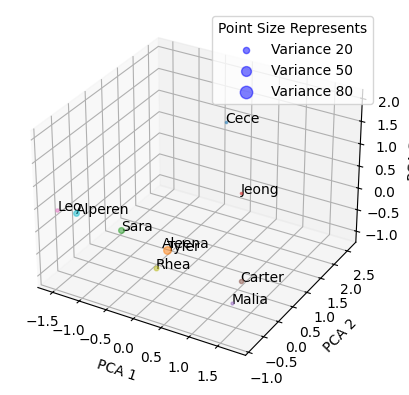

In [63]:
# SIMILAR USERS: Calculate pairwise Euclidean distances
print("Raw Euclidean Distances:")
distances = pd.DataFrame(squareform(pdist(user_new, 'euclidean')), 
                         index=user_new.index, 
                         columns=user_new.index)

# To avoid selecting the same user, set the diagonals to a high number
np.fill_diagonal(distances.values, np.inf)

# For each user, find the name of the closest other user
for user in distances.index:
    closest_user = distances.loc[user].idxmin()
    print(f"{user} is most similar to {closest_user}")

data_matrix = user_new
variances = data_matrix.var(axis=1)
scaled_variances = (variances - variances.min()) / (variances.max() - variances.min()) * 100

# PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data_matrix)

# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each user as a point in 3D space
for i, user_name in enumerate(data_matrix.index):
    x, y, z = reduced_data[i, 0], reduced_data[i, 1], reduced_data[i, 2]
    ax.scatter(x, y, z, s=250*(1/scaled_variances[i]), alpha=0.5)  # Alpha = opacity
    ax.text(x, y, z, user_name)  # Label each point with the user's name

# Creating dummy points for legend
for point in [20, 50, 80]:
    ax.scatter([], [], [], s=point, c="blue", alpha=0.5, label=f'Variance {point}')

# Label the plot
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend(title='Point Size Represents')
plt.show()



Euclidean distance of PCA results:
Cece is most similar to Aleena
Tyler is most similar to Aleena
Sara is most similar to Aleena
Jeong is most similar to Tyler
Malia is most similar to Carter
Carter is most similar to Malia
Leo is most similar to Alperen
Aleena is most similar to Tyler
Rhea is most similar to Tyler
Alperen is most similar to Leo


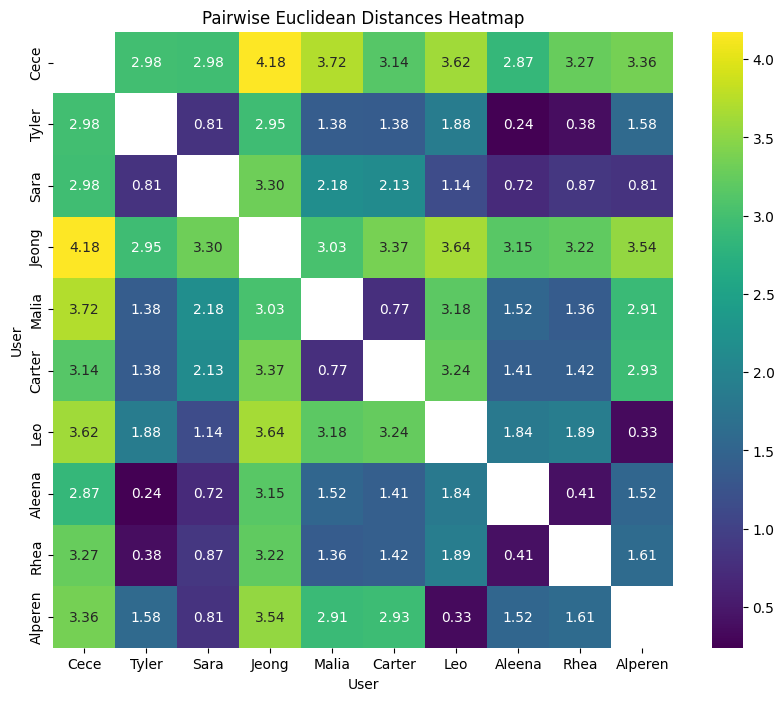

In [64]:
# comparison of distance on PCA results:
print("Euclidean distance of PCA results:")
data_matrix = user_new
variances = data_matrix.var(axis=1)
scaled_variances = (variances - variances.min()) / (variances.max() - variances.min()) * 100

# Perform PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data_matrix)

# Calculate pairwise Euclidean distances using the PCA-transformed data
distances_pca = pd.DataFrame(squareform(pdist(reduced_data, 'euclidean')), 
                             index=data_matrix.index, 
                             columns=data_matrix.index)

# Set the diagonals to a high number to avoid self-comparison
np.fill_diagonal(distances_pca.values, np.inf)

# Find the name of the closest other user based on PCA-transformed distances
for user in distances_pca.index:
    closest_user = distances_pca.loc[user].idxmin()
    print(f"{user} is most similar to {closest_user}")

#HEATMAP
np.fill_diagonal(distances_pca.values, np.nan)
plt.figure(figsize=(10, 8))
sns.heatmap(distances_pca, annot=True, fmt=".2f", cmap='viridis')
plt.title("Pairwise Euclidean Distances Heatmap")
plt.show()





/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


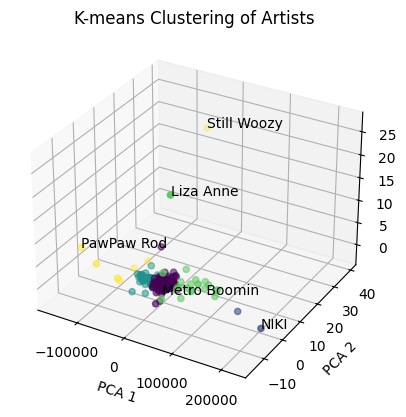

In [73]:
# kmeans by ARTIST

artists_transposed = playlist_new.T
artists_transposed = artists_transposed.drop('Joey Bada$$')
artists_transposed = artists_transposed.drop('Stephan Bodzin')
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(artists_transposed)

# Apply PCA to reduce the dimensions to 2 or 3
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(artists_transposed)

# Find indices of min and max for each PCA component
min_indices = reduced_data.argmin(axis=0)
max_indices = reduced_data.argmax(axis=0)

# Combine these indices (they might be not unique if min and max are the same for some component)
label_indices = set(min_indices) | set(max_indices)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=clusters, cmap='viridis', marker='o')

# Annotating points with min and max PCA values
for i, artist_name in enumerate(artists_transposed.index):
    # Label the min and max points for each PCA component
    if i in label_indices:
        safe_name = artist_name.encode('ascii', 'ignore').decode()
        ax.text(reduced_data[i, 0], reduced_data[i, 1], reduced_data[i, 2], safe_name, usetex=False)

ax.set_title('K-means Clustering of Artists')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

plt.show()

In [70]:
## top 5 recommendation

# recommend 5 top artists from the highest recommended complete matrix per user, that has No value in complete df per each user
def recommend(type, user):
    if type == 'playlist':
        orig = playlist_original_df
        complete = playlist_new
        col_name = 'Playlist Name'
    else:
        orig = users_original_df
        complete = user_new
        col_name = 'User'

    if orig.index.name != col_name:
        orig = orig.set_index(col_name)
    if complete.index.name != col_name:
        complete = complete.set_index(col_name)

    # Check if user exists in the original df
    if user not in orig.index:
        raise ValueError("User not found in the original DataFrame")

    # Extract user's data from original and complete matrices
    user_orig_data = orig.loc[user]
    user_complete_data = complete.loc[user]

    # artists that the user hasn't rated/listened to in original df
    unrated_artists = user_orig_data[user_orig_data.isna() | (user_orig_data == 0)].index

    recommendations = user_complete_data[unrated_artists]
    top_recommendations = recommendations.sort_values(ascending=False).head(10)

    return top_recommendations.index.tolist()

## PLAYLIST
print(recommend('playlist', 'Jeong/timeless'))
## USER 
print(recommend('user', 'Jeong'))

['PawPaw Rod', 'Swae Lee', 'Jungle', 'Stevie Wonder', 'Travis Scott', 'Victoria Monét', 'Drake', 'The Beatles', 'Yeek', 'Julien Baker']
['Swae Lee', 'Crumb', 'Baird', 'PawPaw Rod', 'Selena Gomez', 'The Silhouettes Project', 'extremely bad man', "Dre'es", 'Fana Hues', 'Loving']


In [77]:
print(users_original_df['PawPaw Rod'])
print(user_new['PawPaw Rod'])

0    NaN
1    9.0
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: PawPaw Rod, dtype: float64
User
Cece      -8.087846e-15
Tyler      1.951220e-01
Sara      -1.204765e-13
Jeong      5.652301e-16
Malia     -7.514822e-17
Carter    -2.831506e-15
Leo       -1.312388e-15
Aleena    -1.273547e-14
Rhea       1.271859e-15
Alperen    7.679276e-05
Name: PawPaw Rod, dtype: float64
